In [1]:
dataset_str = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

In [2]:
dataset_str = 'Deng_Liu_LUAD_2024'
data_dir = '/root/datos/maestria/netopaas'

In [3]:
import anndata
import scanpy as sc
from pandas import read_csv

In [10]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{dataset_str}.h5ad')
adata

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 488236 × 33336
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'Patient Number_x', 'Group_x', 'Sex_x', 'Age （years）_x', 'Current or former smoking_x', 'Cancer history_x', 'Tumor location_x', 'Tumor size（cm）_x', 'Pathology_x', 'Histological subtype_x', 'T stage_x', 'N stage_x', 'M stage_x', 'Pathological stage_x', 'Patient Number_y', 'Group_y', 'Sex_y', 'Age （years）_y', 'Current or former smoking_y', 'Cancer history_y', 'Tumor location_y', 'Tumor size（cm）_y', 'Pathology_y', 'Histological subtype_y', 'T stage_y', 'N stage_y', 'M stage_y', 'Pathological stage_y'
    var: 'features'
    obsm: 'X_tsne', 'X_umap'
    layers: 'data'

## 3.1.1 Automated annotation

For a more detailed walkthrough of the process go to `../HCA-Lung/AutoLung.ipynb` or even https://docs.scarches.org/en/latest/hlca_map_classify.html

IT IS IMPORTANT THAT THE QUERY DATA IS IN RAW COUNTS, WE CHECK THAT HERE:


In [11]:
adata.X[:20, :20].toarray()

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
        2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        2., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [4]:
import pandas as pd
import anndata as ad
import numpy as np

import scarches as sca
import gdown
import gzip
import shutil
from scipy import sparse

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(8, 8))

 
 
 

/usr/local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
2024-06-21 04:53:46.367304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 04:53:46.367364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 04:53:46.368968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:

### Load Query dataset

In [5]:
batch_key = 'dataset'
name = dataset_str.split('_')[0]
query_batch = [f'lung_{name}']
cell_type_key = 'scanvi_label'
data_dir = '/root/datos/maestria/netopaas/lung_scRNA'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
ref_model_path = f'{data_dir}/LUCA_model/full_atlas_hvg_integrated_scvi_scanvi_model'

#Important to check how many epochs would be ideal
surgery_epochs = 100
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [6]:
adata_ref = sc.read_h5ad(f'{data_dir}/LUCA_model/full_atlas_hvg_integrated_scvi_integrated_scanvi.h5ad')

For faster computation convert the matrix to sparse.
First check with `adata.X` if it is sparse

In [11]:
adata.X
# adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

<51947x18447 sparse matrix of type '<class 'numpy.float32'>'
	with 79354831 stored elements in Compressed Sparse Row format>

In [ ]:
adata_query_unprep = adata.copy()

### Change to Ensembl IDs

Revert to ensemble ids using the assembly reference gch38 (or hg19 in the comments) used in the experiment.
Doing this via THE PACKAGE Biomart always leaves us with some gaps because there are many manually annotated genes.

If your query feature naming does not match your reference model feature naming, you will need to add the right feature names. For the HLCA reference, the mapping of the 2000 input gene IDs to their gene names is stored on the HLCA Zenodo page, so you can add gene ids using that mapping. Alternatively, you can map your gene IDs to gene names (or the reverse) using BioMart mapping tables. In most cases your raw data includes both gene IDs and names, in which case mapping is not necessary.

Let’s download the HLCA-specific gene mapping:

In [7]:
path_gene_mapping_df = f'{data_dir}/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv'

In [50]:
# Download gene information from HLCA github:
# url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv"
# gdown.download(url, path_gene_mapping_df, quiet=False)

In [15]:
gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

# Store your gene names in an adata.var.column if they are currently the index:
# if gene names are in .var.index:
adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index
gene_name_column_name = "gene_names"

Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data:

Check number of detected genes:

In [16]:
n_overlap = (
    adata_query_unprep.var[gene_name_column_name]
    .isin(gene_id_to_gene_name_df.gene_symbol)
    .sum()
)
n_genes_model = gene_id_to_gene_name_df.shape[0]
print(
    f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)



Number of model input genes detected: 1900 out of 2000 (95%)


Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index (for scArches) and in a .var[gene_ids] (for merging duplicate genes).

In [17]:
adata_query_unprep = adata_query_unprep[
    :,
    adata_query_unprep.var[gene_name_column_name].isin(
        gene_id_to_gene_name_df.gene_symbol
    ),
].copy()  # subset your data to genes used in the reference model
adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
    dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
)  # add gene ids for the gene names, and store in .var.index
# remove index name to prevent bugs later on
adata_query_unprep.var.index.name = None
adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index


In [101]:
adata_query_unprep.var.index.name = None

In [102]:
adata_query_unprep.var.head(3)

features
AL627309.1  AL627309.1
AL627309.5  AL627309.5
AP006222.2  AP006222.2

In [18]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    adata.obs[col] = adata.obs[col].astype('category')
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    cat = adata.obs[col].values
    indicator = sparse.coo_matrix(
        (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
        shape=(len(cat.categories), adata.n_obs),
    )

    return ad.AnnData(
        indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
    )

shape before merging:

Now merge. Note that all var columns will be dropped after merging (as we don’t specify how to merge). As the merging is done based on .obs indices in the function above, we transpose our anndata object and re-transpose it after merging.

In [19]:
adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

In [103]:
adata_query_unprep.shape

(488236, 33336)

add back gene ids:

In [20]:
adata_query_unprep.var = adata_query_unprep.var.join(gene_id_to_gene_name_df).rename(columns={"gene_symbol":"gene_names"})

### Surgery

In [ ]:
adata_query_unprep.var.index.name = None

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [105]:
# If you get a TypeError consider downgrading pandas to 1.54 for this older model
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    # return_reference_var_names=True,
    reference_model = ref_model_path,
    inplace=False)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/full_atlas_hvg_integrated_scvi_scanvi_model/model.pt  
         already downloaded                                                                                        
INFO     Found 98.11666666666666% reference vars in query data.                                                    


/usr/local/lib/python3.11/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [106]:
adata_query.obs['scanvi_label'] = 'unlabeled'

Now we perform scArches “surgery”.

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [9]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(ref_model_path, load_adata=False, map_location='cpu')

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/full_atlas_hvg_integrated_scvi_scanvi_model/model.pt  
         already downloaded                                                                                        


Thanks to exploring the model we can deduce what .obs we need and the name we assigned. In this case we need to define a 'dataset'
column in obs to define the batches. Seeing as to how every sample ia new day in the experiment we define the batches as the samples.

We can load the model with this command or train it if we havent got it

In [107]:
adata_query.obs['dataset'] = adata_query.obs['orig.ident']
adata_query.obs['orig.ident'] = adata_query.obs['orig.ident'].astype('string')
adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('string')
adata_query.obs['sample'] = adata_query.obs['dataset']

In [111]:
for col in adata_query.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_query.obs[col]):
        adata_query.obs[col] = adata_query.obs[col].astype('str')


In [112]:
# Convert all mito falgs into false because we are using the latent genes of the HCA_lung model
# adata_query = sc.read_h5ad(f'{backup_dir}/query_{name}.h5ad')
adata_query.var.mito = False
adata_query.write_h5ad(f'{backup_dir}/query_{name}.h5ad')

IORegistryError: No method registered for writing <class 'pandas.core.arrays.string_.StringArray'> into <class 'h5py._hl.group.Group'>

Apparently we have to aks for cuda availability explicitly for scArches to recognize that we have GPU

In [91]:
import torch
torch.cuda.is_available()

False

In [92]:
adata_query.shape

(488236, 2000)

In [113]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/full_atlas_hvg_integrated_scvi_scanvi_model/model.pt  
         already downloaded                                                                                        


/usr/local/lib/python3.11/site-packages/scvi/data/_manager.py:216: UserWarning: Missing labels key cell_type. Filling in with unlabeled category unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [ ]:
%%time
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 100 epochs.                                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 54/100:  53%|█████████████████████████████████████████████████▊                                            | 53/100 [2:20:40<2:24:51, 184.92s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.41e+3]

In [ ]:
surgery_model.save(f'{backup_dir}/{name}2', overwrite=True)

In [38]:
# surgery_model = sca.models.SCANVI.load(f'{backup_dir}/{name}/', adata_query)

### Get latent representation
Here we will calculate the “latent representation”, or “low-dimensional embedding” of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [38]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

### Combine embeddings
We add “reference or query” metadata to acquire more information and better analyse the integration level.

In [39]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. “_” and batch_key to the obs column that you want to use as barcode suffix (e.g. “dataset”).

In [40]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

/tmp/ipykernel_515683/994811194.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative
/usr/local/lib/python3.11/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

### Label transfer
Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5). Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. (Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [41]:
celltypes = f'{data_dir}/HCA_Lung/HLCA_celltypes_ordered.csv'

In [100]:
# url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
# gdown.download(url, celltypes, quiet=False)

In [46]:
cts_ordered = read_csv(celltypes,index_col=0)

We make make a mapping from the the cells in the LUCA atlas to the cells in the HLCA atlas to get a hierarchy of types. We define the hierarchy manually for cancer cells.

In [56]:
mapping = {
    'Monocyte non-classical': 'Non-classical monocytes',
    'Macrophage alveolar': 'Alveolar macrophages',
    'Endothelial cell lymphatic': 'Lymphatic EC mature',
    'Macrophage': 'Alveolar macrophages',  # Assuming general macrophages are alveolar
    'Monocyte classical': 'Classical monocytes',
    'Tumor cells LUAD': '',  # No direct match in the target array
    'T cell CD8 dividing': 'T cells proliferating',
    'myeloid dividing': 'myeloid dividing',
    'NK cell': 'NK cells',
    'cDC2': 'DC2',
    'B cell': 'B cells',
    'Endothelial cell capillary': 'EC general capillary',
    'T cell regulatory': 'T cell regulatory',
    'ROS1+ healthy epithelial': 'Basal resting',
    'Alveolar cell type 1': 'AT1',
    'Endothelial cell venous': 'EC venous systemic',
    'T cell CD4': 'CD4 T cells',
    'Endothelial cell arterial': 'EC arterial',
    'Fibroblast adventitial': 'Adventitial fibroblasts',
    'Plasma cell': 'Plasma cells',
    'T cell CD8 naive': 'CD8 T cells',
    'Smooth muscle cell': 'Smooth muscle',
    'Ciliated': 'Multiciliated (non-nasal)',
    'transitional club/AT2': 'Transitional Club-AT2',
    'T cell CD8 effector memory': 'CD8 T cells',
    'Club': 'Club (non-nasal)',
    'T cell CD4 dividing': 'T cells proliferating',
    'T cell NK-like': 'NK cells',
    'Mesothelial': 'Mesothelium',
    'Fibroblast alveolar': 'Alveolar fibroblasts',
    'Alveolar cell type 2': 'AT2',
    'T cell CD8 activated': 'CD8 T cells',
    'Tumor cells LUSC mitotic': '',  # No direct match in the target array
    'NK cell dividing': 'NK cells',
    'cDC1': 'DC1',
    'Mast cell': 'Mast cells',
    'stromal dividing': 'stromal dividing',
    'Plasma cell dividing': 'Plasma cells',
    'pDC': 'Plasmacytoid DCs',
    'T cell CD8 terminally exhausted': 'CD8 T cells',
    'DC mature': 'Migratory DCs',
    'Pericyte': 'Pericytes',
    'Fibroblast peribronchial': 'Peribronchial fibroblasts',
    'Tumor cells LUAD mitotic': '',  # No direct match in the target array
    'Neutrophils': 'Neutrophils',
    'Tumor cells LUAD EMT': '',  # No direct match in the target array
    'Tumor cells NSCLC mixed': '',  # No direct match in the target array
    'Tumor cells LUSC': '',  # No direct match in the target array
    'B cell dividing': 'B cells',
    'Tumor cells LUAD NE': '',  # No direct match in the target array
    'Tumor cells LUAD MSLN': ''  # No direct match in the target array
}

# Create a DataFrame from the mapping dictionary
df_mapping = pd.DataFrame(list(mapping.items()), columns=['Source', 'Target'])
df_mapping

Source                     Target
0            Monocyte non-classical    Non-classical monocytes
1               Macrophage alveolar       Alveolar macrophages
2        Endothelial cell lymphatic        Lymphatic EC mature
3                        Macrophage       Alveolar macrophages
4                Monocyte classical        Classical monocytes
5                  Tumor cells LUAD                           
6               T cell CD8 dividing      T cells proliferating
7                  myeloid dividing           myeloid dividing
8                           NK cell                   NK cells
9                              cDC2                        DC2
10                           B cell                    B cells
11       Endothelial cell capillary       EC general capillary
12                T cell regulatory          T cell regulatory
13         ROS1+ healthy epithelial              Basal resting
14             Alveolar cell type 1                        AT1
15          Endothelial cell venous         EC venous systemic
16                       T cell CD4                CD4 T cells
17        Endothelial cell arterial                EC arterial
18           Fibroblast adventitial    Adventitial fibroblasts
19                      Plasma cell               Plasma cells
20                 T cell CD8 naive                CD8 T cells
21               Smooth muscle cell              Smooth muscle
22                         Ciliated  Multiciliated (non-nasal)
23            transitional club/AT2      Transitional Club-AT2
24       T cell CD8 effector memory                CD8 T cells
25                             Club           Club (non-nasal)
26              T cell CD4 dividing      T cells proliferating
27                   T cell NK-like                   NK cells
28                      Mesothelial                Mesothelium
29              Fibroblast alveolar       Alveolar fibroblasts
30             Alveolar cell type 2                        AT2
31             T cell CD8 activated                CD8 T cells
32         Tumor cells LUSC mitotic                           
33                 NK cell dividing                   NK cells
34                             cDC1                        DC1
35                        Mast cell                 Mast cells
36                 stromal dividing           stromal dividing
37             Plasma cell dividing               Plasma cells
38                              pDC           Plasmacytoid DCs
39  T cell CD8 terminally exhausted                CD8 T cells
40                        DC mature              Migratory DCs
41                         Pericyte                  Pericytes
42         Fibroblast peribronchial  Peribronchial fibroblasts
43         Tumor cells LUAD mitotic                           
44                      Neutrophils                Neutrophils
45             Tumor cells LUAD EMT                           
46          Tumor cells NSCLC mixed                           
47                 Tumor cells LUSC                           
48                  B cell dividing                    B cells
49              Tumor cells LUAD NE                           
50            Tumor cells LUAD MSLN

In [76]:
cts_ordered2 = df_mapping.join(cts_ordered, on='Target')
cts_ordered2 = cts_ordered2.set_index('Source')
cts_ordered2.ordering = cts_ordered2.ordering.astype('Int16')
cts_ordered2 = cts_ordered2.sort_values(by='ordering').drop('Target', axis=1)

In [91]:
cts_ordered2.loc['myeloid dividing', :] = ['Immune', 'Myeloid', '2_Myeloid', '2_Myeloid', '2_Myeloid',160,"#f5faa0"]
cts_ordered2.loc['Neutrophils', :] = ['Immune', 'Myeloid', '2_Myeloid', '2_Myeloid', '2_Myeloid',165,"#aafaa0"]
cts_ordered2.loc['T cell regulatory', :] = ['Immune', 'Lymphoid', 'T cell lineage', 'CD4 T cells', 'T cell regulatory',118,"#d0a0fa"]
cts_ordered2.loc['stromal dividing', :] = ['Stromal', 'Stromal dividing', '2_Stromal dividing', '2_Stromal dividing', '2_Stromal dividing',70,"#630049"]
cts_ordered2.loc['Tumor cells NSCLC mixed', :] = ['Epithelial', 'Tumor', 'NSCLC', '3_NSCLC', '3_NSCLC',47,"#630049"]
cts_ordered2.loc['Tumor cells LUSC mitotic', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUSC', '4_LUSC',48,"#630049"]
cts_ordered2.loc['Tumor cells LUSC', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUSC', '4_LUSC',48,"#630049"]
cts_ordered2.loc['Tumor cells LUAD', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUAD', '4_LUAD',49,"#630049"]
cts_ordered2.loc['Tumor cells LUAD mitotic', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUAD', '4_LUAD',50,"#630049"]
cts_ordered2.loc['Tumor cells LUAD EMT', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUAD', '4_LUAD',51,"#630049"]
cts_ordered2.loc['Tumor cells LUAD NE', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUAD', '4_LUAD',52,"#630049"]
cts_ordered2.loc['Tumor cells LUAD MSLN', :] = ['Epithelial', 'Tumor', 'NSCLC', 'LUAD', '4_LUAD',53,"#630049"]
cts_ordered2 = cts_ordered2.sort_values(by='ordering')

cts_ordered2

Level_1              Level_2  \
Source                                                              
ROS1+ healthy epithelial          Epithelial    Airway epithelium   
Ciliated                          Epithelial    Airway epithelium   
Club                              Epithelial    Airway epithelium   
transitional club/AT2             Epithelial    Airway epithelium   
Alveolar cell type 1              Epithelial  Alveolar epithelium   
Alveolar cell type 2              Epithelial  Alveolar epithelium   
Tumor cells NSCLC mixed           Epithelial                Tumor   
Tumor cells LUSC                  Epithelial                Tumor   
Tumor cells LUSC mitotic          Epithelial                Tumor   
Tumor cells LUAD                  Epithelial                Tumor   
Tumor cells LUAD mitotic          Epithelial                Tumor   
Tumor cells LUAD EMT              Epithelial                Tumor   
Tumor cells LUAD NE               Epithelial                Tumor   
Tumor cells LUAD MSLN             Epithelial                Tumor   
Endothelial cell arterial        Endothelial        Blood vessels   
Endothelial cell capillary       Endothelial        Blood vessels   
Endothelial cell venous          Endothelial        Blood vessels   
Endothelial cell lymphatic       Endothelial         Lymphatic EC   
stromal dividing                     Stromal     Stromal dividing   
Fibroblast peribronchial              Stroma   Fibroblast lineage   
Fibroblast adventitial                Stroma   Fibroblast lineage   
Fibroblast alveolar                   Stroma   Fibroblast lineage   
Pericyte                              Stroma   Fibroblast lineage   
Smooth muscle cell                    Stroma        Smooth muscle   
Mesothelial                           Stroma          Mesothelium   
B cell dividing                       Immune             Lymphoid   
B cell                                Immune             Lymphoid   
Plasma cell                           Immune             Lymphoid   
Plasma cell dividing                  Immune             Lymphoid   
T cell CD4                            Immune             Lymphoid   
T cell CD8 terminally exhausted       Immune             Lymphoid   
T cell CD8 activated                  Immune             Lymphoid   
T cell CD8 effector memory            Immune             Lymphoid   
T cell CD8 naive                      Immune             Lymphoid   
T cell CD4 dividing                   Immune             Lymphoid   
T cell CD8 dividing                   Immune             Lymphoid   
T cell regulatory                     Immune             Lymphoid   
NK cell dividing                      Immune             Lymphoid   
NK cell                               Immune             Lymphoid   
T cell NK-like                        Immune             Lymphoid   
cDC1                                  Immune              Myeloid   
cDC2                                  Immune              Myeloid   
DC mature                             Immune              Myeloid   
pDC                                   Immune              Myeloid   
Macrophage                            Immune              Myeloid   
Macrophage alveolar                   Immune              Myeloid   
Monocyte classical                    Immune              Myeloid   
Monocyte non-classical                Immune              Myeloid   
Mast cell                             Immune              Myeloid   
myeloid dividing                      Immune              Myeloid   
Neutrophils                           Immune              Myeloid   

                                                 Level_3  \
Source                                                     
ROS1+ healthy epithelial                           Basal   
Ciliated                           Multiciliated lineage   
Club                                           Secretory   
transitional club/AT2                          Secretory   
Alveolar cell type 

In [92]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [95]:
adata_ref

AnnData object with n_obs × n_vars = 892296 × 6000
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'cell_type', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'cell_type_major', '_scvi_batch', '_scvi_labels', 'ref_or_query'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_coarse_colors', 'cell_type_major_colors', 'cell_type_predicted_colors', 'condition_colors', 'd

In [93]:
%%time

labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered2, on='cell_type_tumor')
    )

ValueError: X has 10 features, but KNeighborsTransformer is expecting 6000 features as input.

With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [104]:
uncertainty_threshold = 0.2

In [105]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [106]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [107]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [108]:
def remove_uncert_types(combined_emb):
    import pandas as pd
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

In [109]:
remove_uncert_types(combined_emb)

AnnData object with n_obs × n_vars = 1073120 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [110]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.72%
Level 2: 3.63%
Level 3: 13.41%
Level 4: 26.82%
Level 5: 28.15%


### UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

#### UMAP Query vs. Reference

In [111]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/usr/local/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/usr/local/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/usr/local/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numb

In [115]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/combined_{name}.h5ad')

In [ ]:
# combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


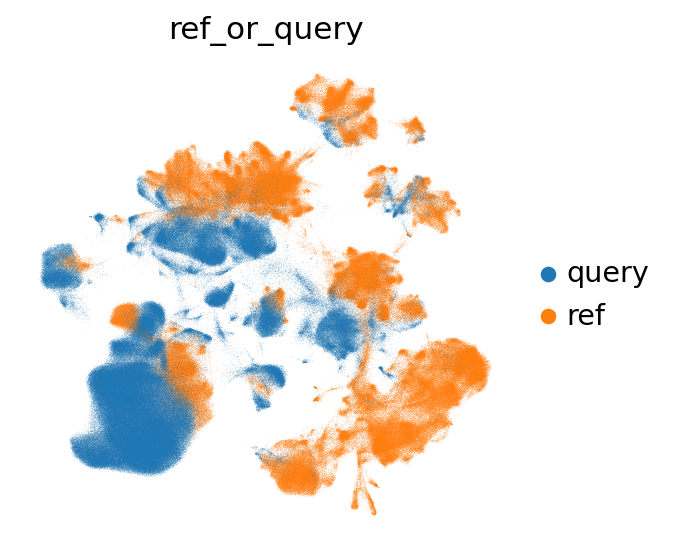

In [112]:
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

#### UMAP Uncertainties

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


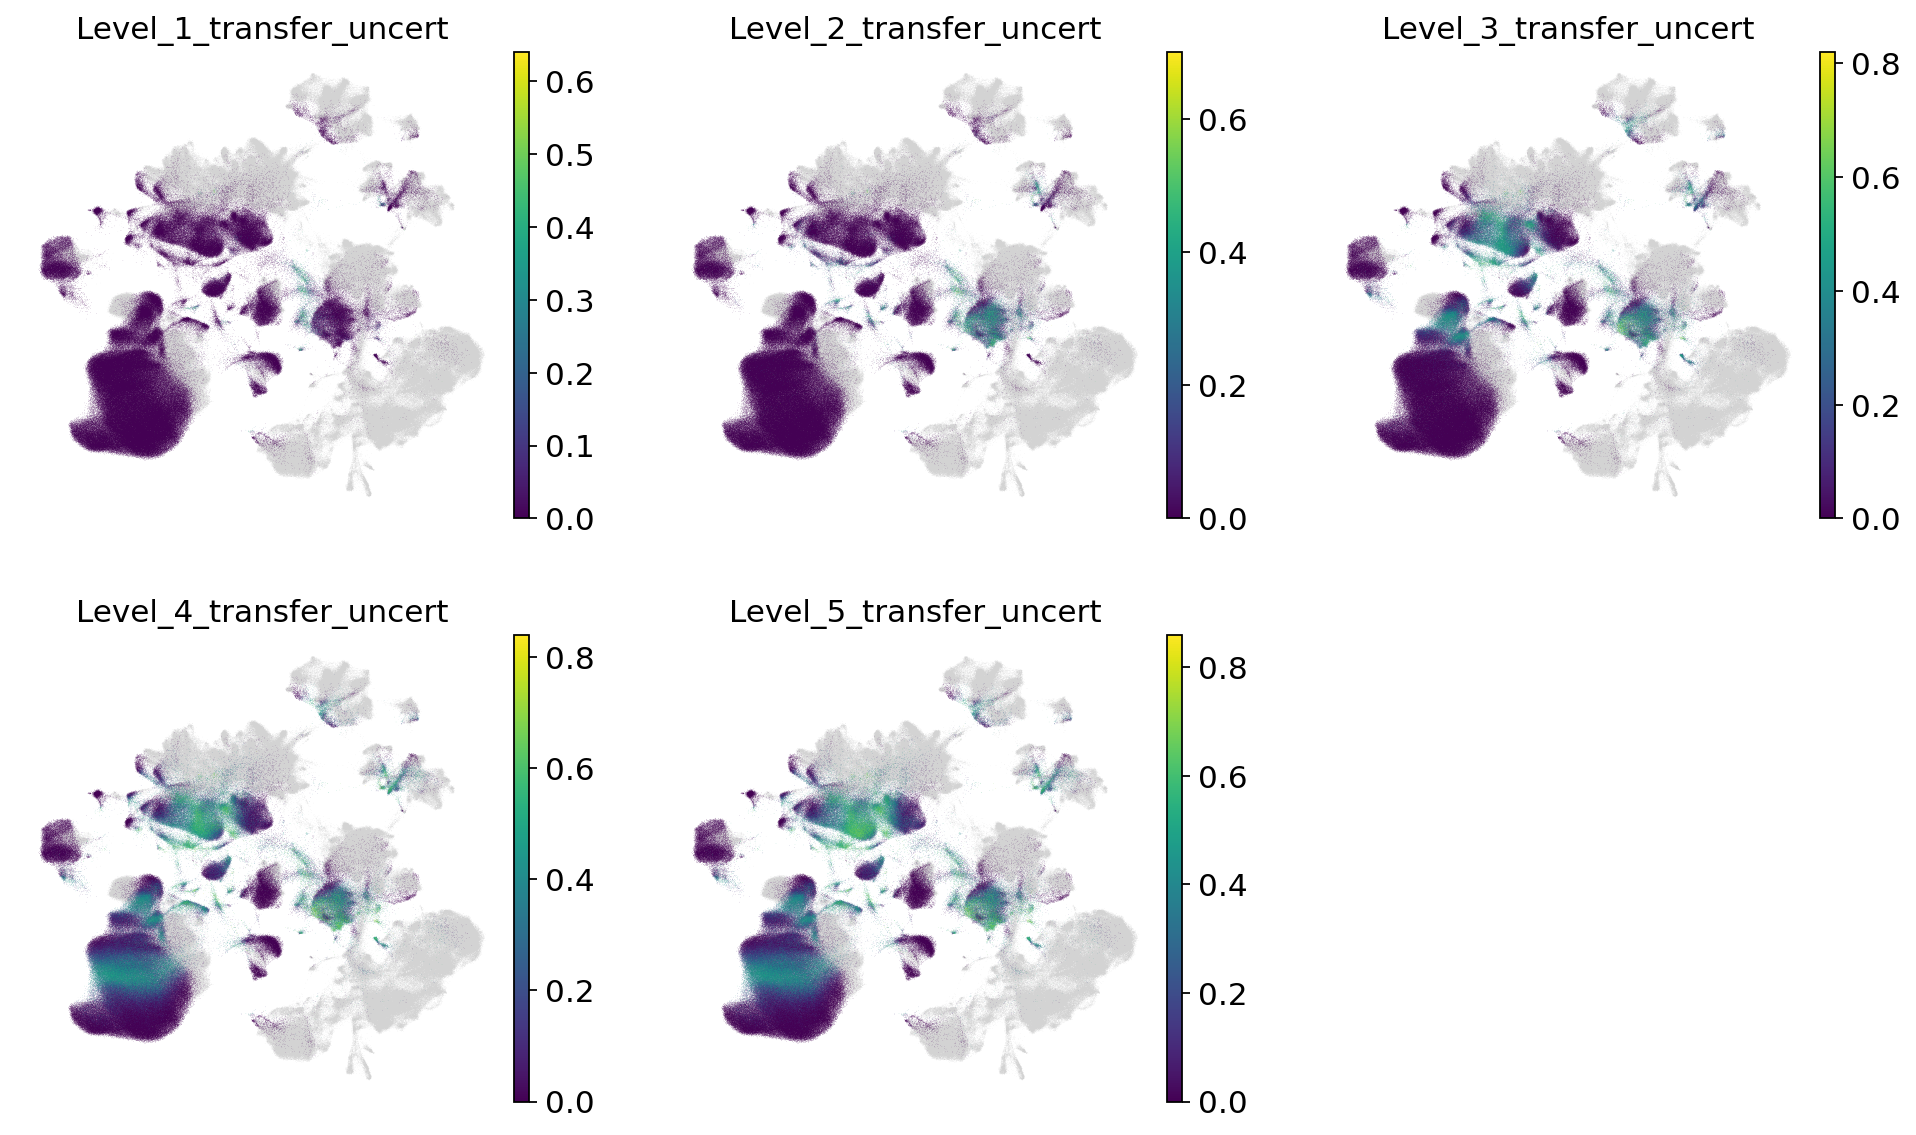

In [113]:
sc.pl.umap(
    combined_emb,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

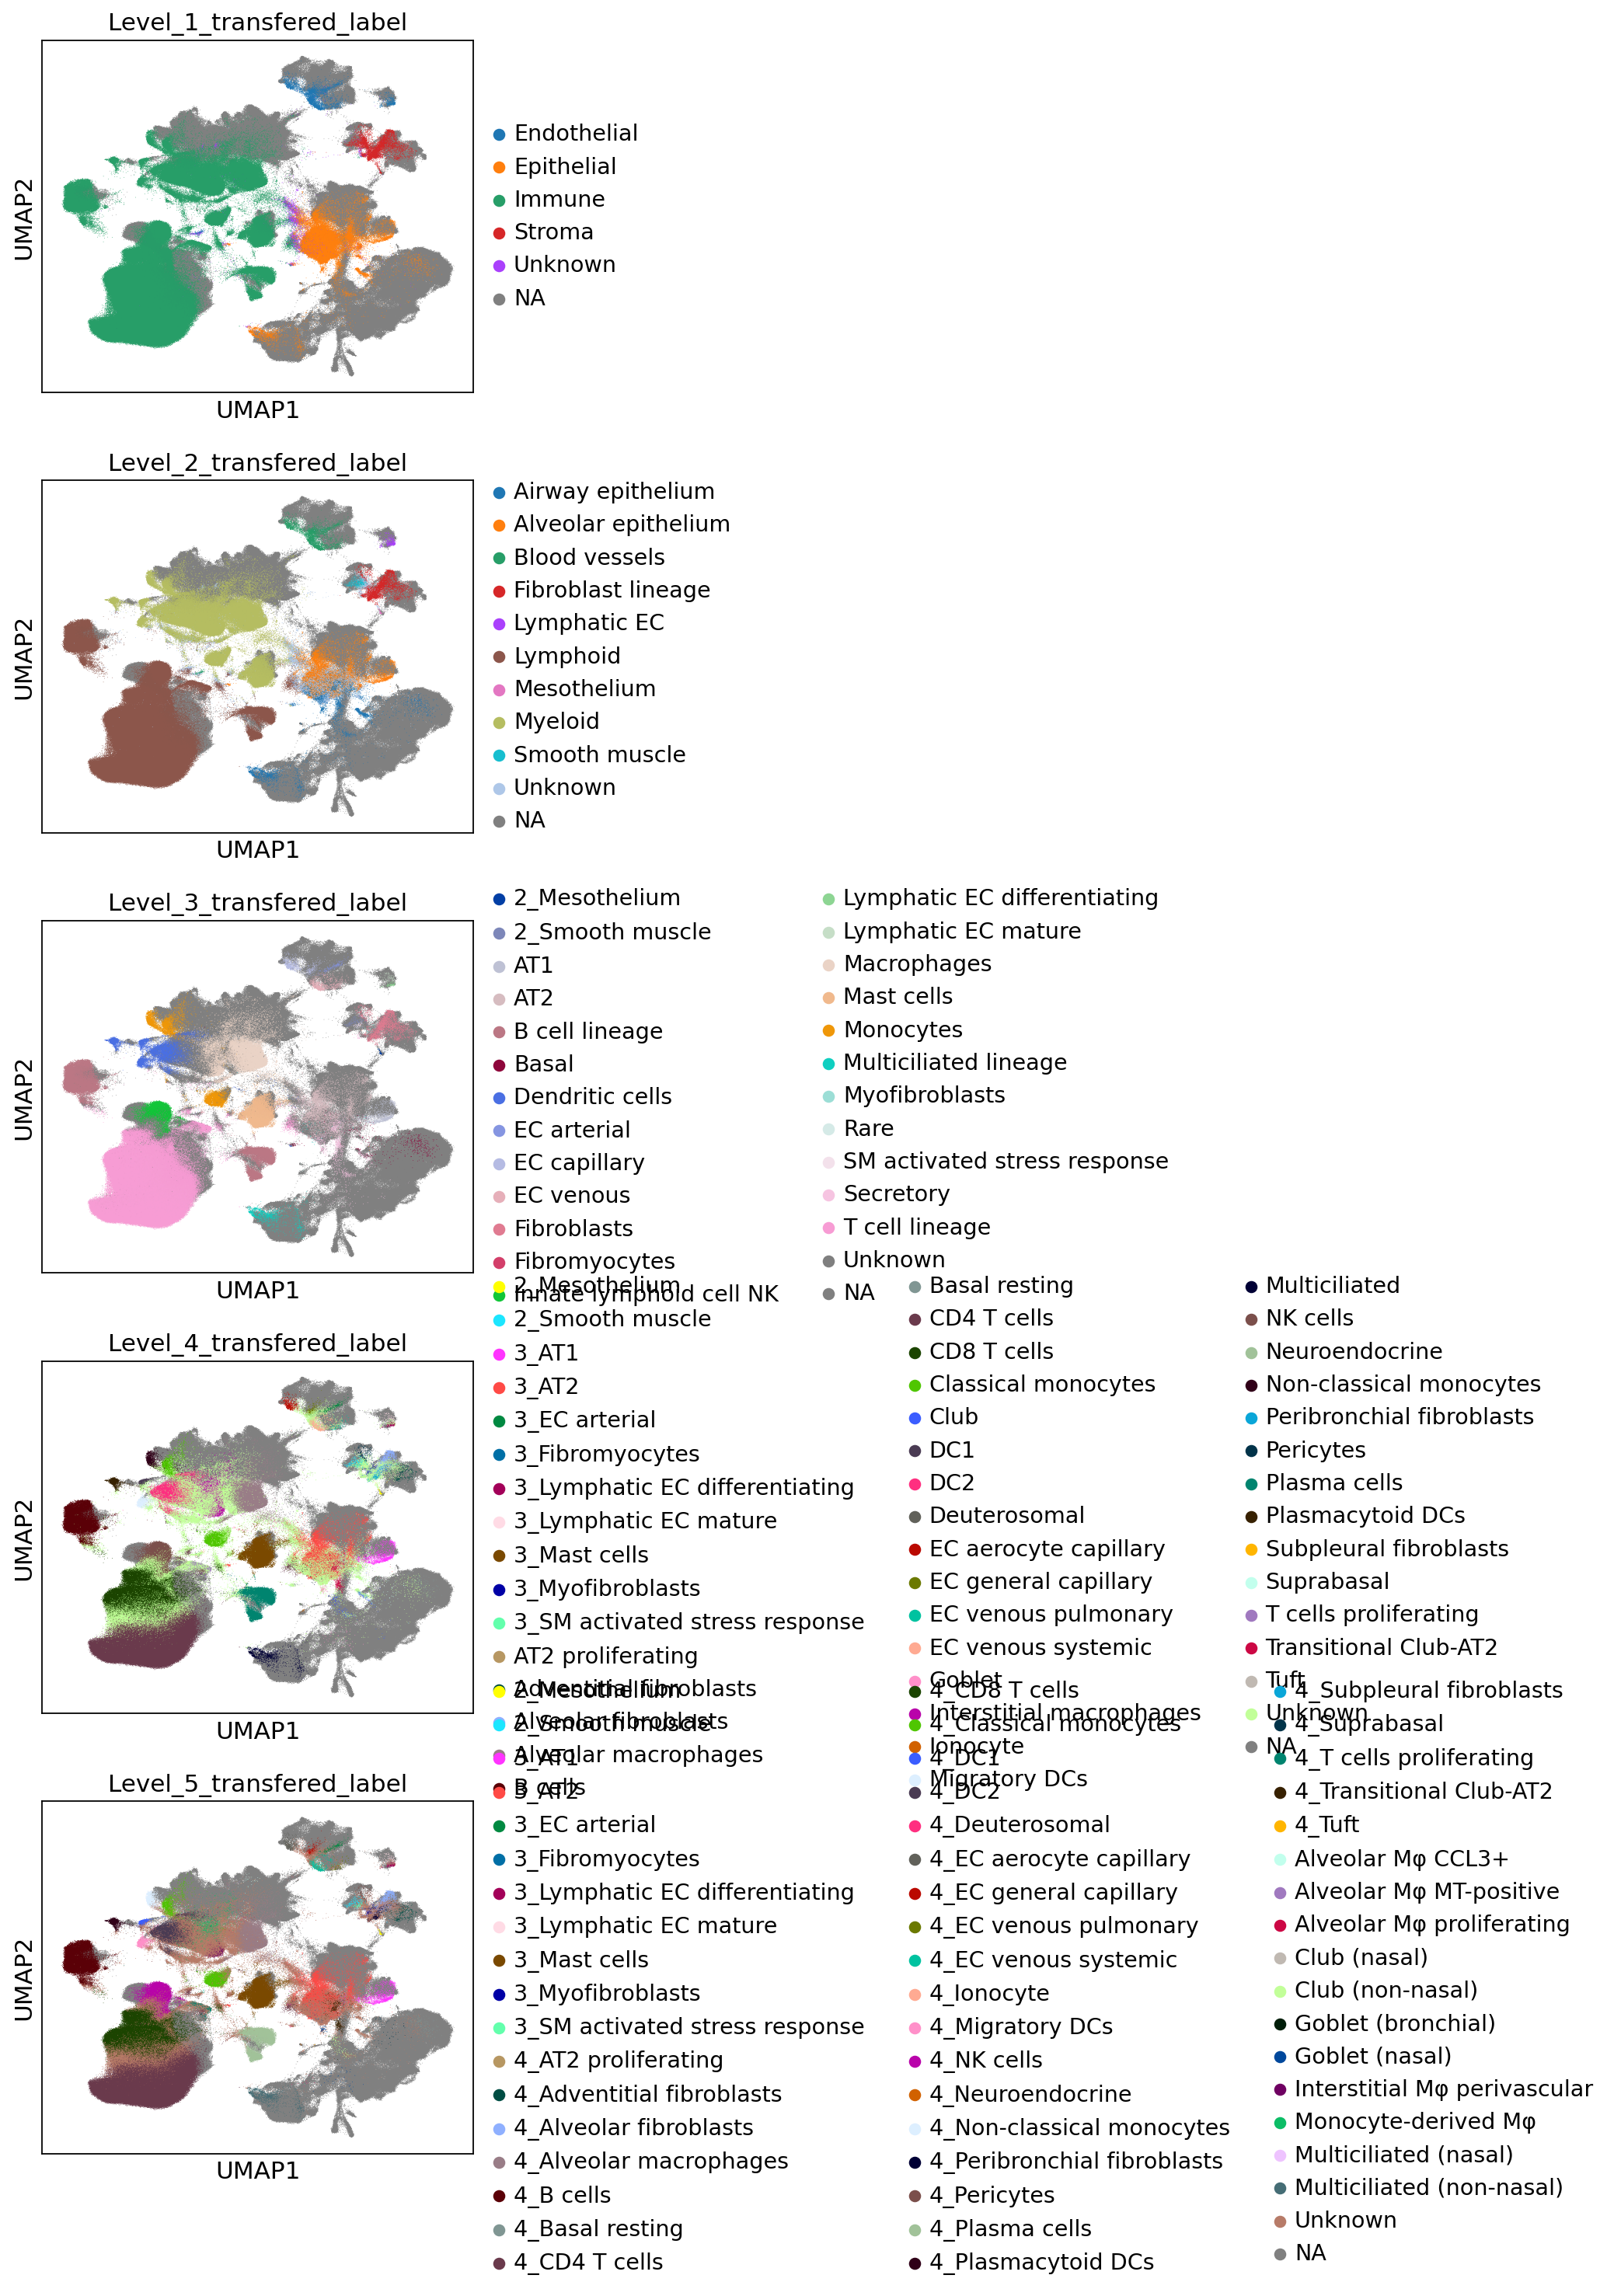

In [156]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

In [170]:
combined_emb.obs['Level_1_transfered_label']

GCGACCATCCCTAACC_SC22       NaN
P2_1_GCGCAACCAGTTAACC       NaN
GCTCTGTAGTGCTGCC_SC27       NaN
P2_8_TTAGGACGTTCAGGCC       NaN
CTTGATTGTCAGTTTG_T164       NaN
                          ...  
488231                   Immune
488232                   Immune
488233                   Immune
488234                   Immune
488235                   Immune
Name: Level_1_transfered_label, Length: 1073120, dtype: category
Categories (5, object): ['Endothelial', 'Epithelial', 'Immune', 'Stroma', 'Unknown']

In [173]:

combined_emb.obs['Level_1_transfered_label'].str.contains('Epith|Unknown')

GCGACCATCCCTAACC_SC22    False
P2_1_GCGCAACCAGTTAACC    False
GCTCTGTAGTGCTGCC_SC27    False
P2_8_TTAGGACGTTCAGGCC    False
CTTGATTGTCAGTTTG_T164    False
                         ...  
488231                   False
488232                   False
488233                   False
488234                   False
488235                   False
Name: Level_1_transfered_label, Length: 1073120, dtype: bool

In [ ]:
ref_emb

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

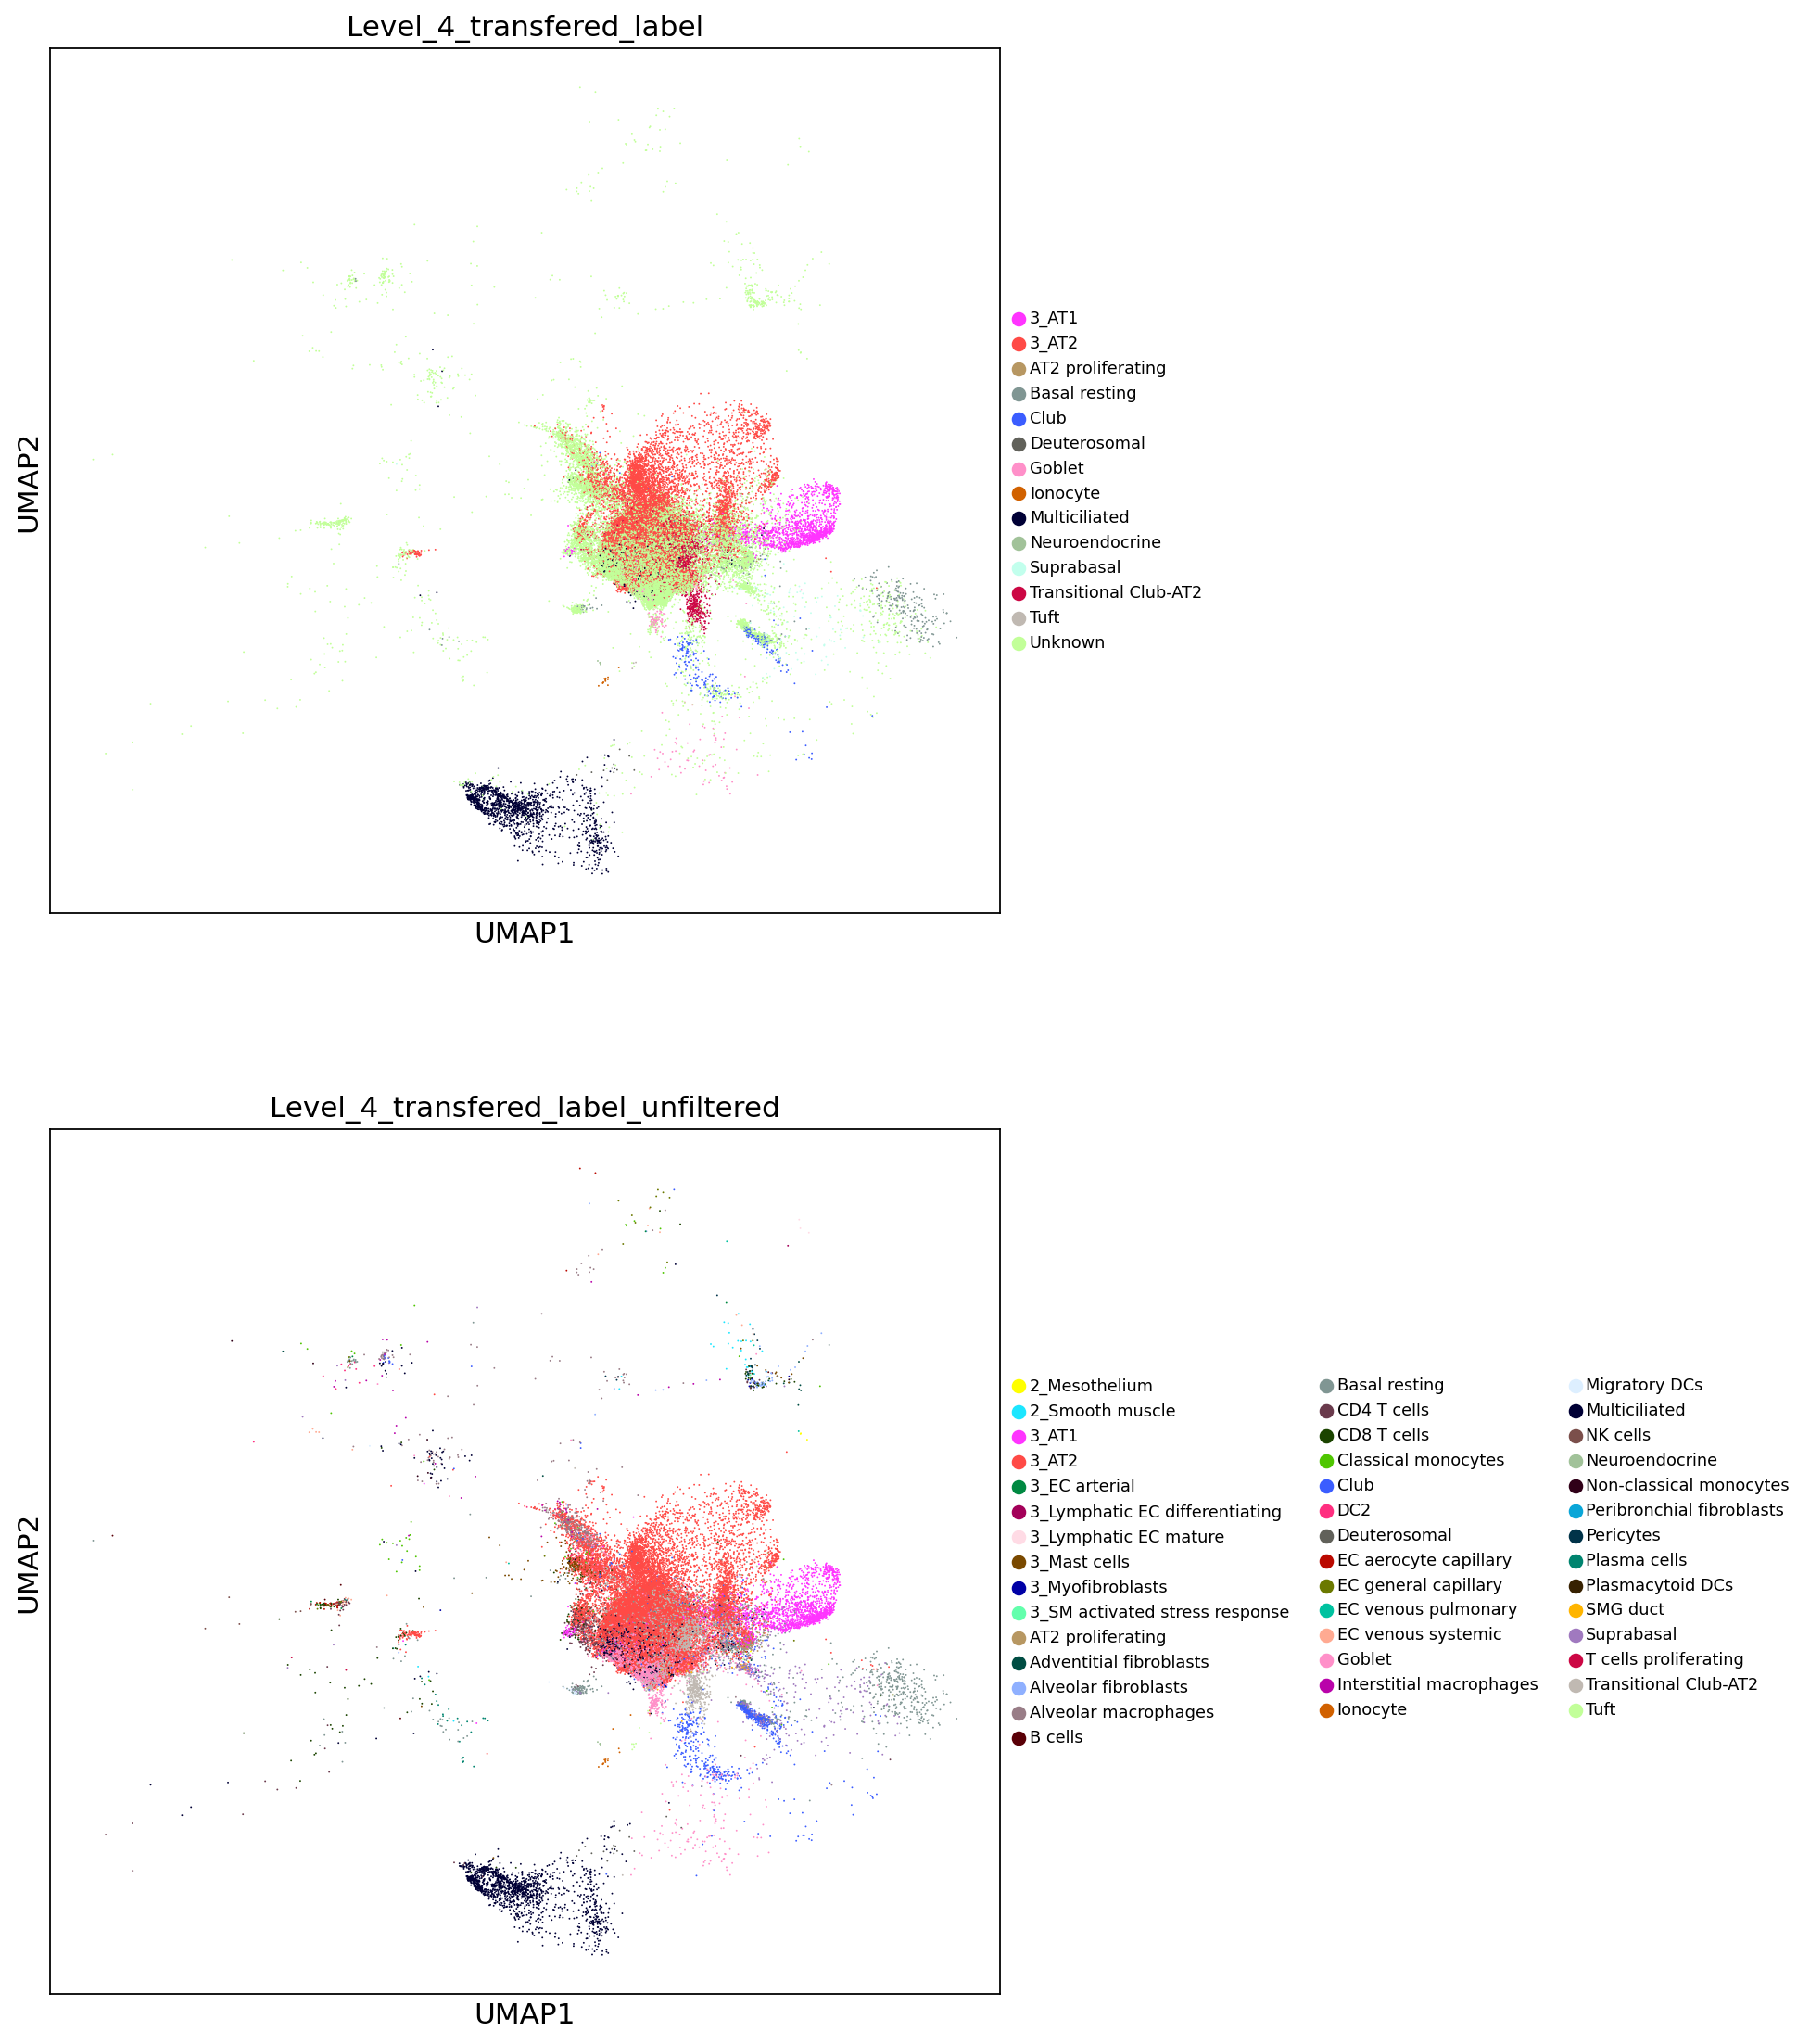

In [175]:
# combined_emb.obs['Level_1_transfered_label'] =combined_emb.obs['Level_1_transfered_label'].cat.add_categories("Query").fillna("Query")
sc.pl.umap(
        combined_emb[combined_emb.obs['Level_1_transfered_label'].str.contains('Epith|Unknown')],
        color=[f"Level_4_transfered_label", f"Level_4_transfered_label_unfiltered"],
        na_color="grey",
        ncols=1,
        # hspace = 0.5,
legend_fontsize=8
)

In [140]:
combined_emb

AnnData object with n_obs × n_vars = 1073120 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_

## Translate atlas cell types to cell_type_tumor

In [88]:
import h5py
from anndata.experimental import read_elem
data_dir = '/root/datos/maestria/netopaas'
with h5py.File("/root/datos/maestria/netopaas/luca/data/atlas/core.h5ad") as f:
    cell_types = read_elem(f["obs/cell_type_tumor"])

cell_types.categories

Index(['Alveolar cell type 1', 'Alveolar cell type 2', 'B cell',
       'B cell dividing', 'Ciliated', 'Club', 'DC mature',
       'Endothelial cell arterial', 'Endothelial cell capillary',
       'Endothelial cell lymphatic', 'Endothelial cell venous',
       'Fibroblast adventitial', 'Fibroblast alveolar',
       'Fibroblast peribronchial', 'Macrophage', 'Macrophage alveolar',
       'Mast cell', 'Mesothelial', 'Monocyte classical',
       'Monocyte non-classical', 'NK cell', 'NK cell dividing', 'Neutrophils',
       'Pericyte', 'Plasma cell', 'Plasma cell dividing',
       'ROS1+ healthy epithelial', 'Smooth muscle cell', 'T cell CD4',
       'T cell CD4 dividing', 'T cell CD8 activated', 'T cell CD8 dividing',
       'T cell CD8 effector memory', 'T cell CD8 naive',
       'T cell CD8 terminally exhausted', 'T cell NK-like',
       'T cell regulatory', 'Tumor cells LUAD', 'Tumor cells LUAD EMT',
       'Tumor cells LUAD MSLN', 'Tumor cells LUAD NE',
       'Tumor cells LUAD mitotic

In [128]:
import h5py
from anndata.experimental import read_elem
data_dir = '/root/datos/maestria/netopaas'
with h5py.File("/root/datos/maestria/netopaas/luca/data/atlas/extended.h5ad") as f:
    cell_types = read_elem(f["obs/cell_type_tumor"])
    atlas_meta = read_elem(f["obs"])

atlas_meta.columns

Index(['sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin',
       'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status',
       'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage',
       'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation',
       'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine',
       'study', 'platform', 'cell_type_major', 'cell_type_neutro',
       'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay',
       'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'obser

In [139]:
[atlas_meta.cell_type_major == 'Tumor cells']

Index(['Alveolar cell type 1', 'Alveolar cell type 2', 'B cell', 'Ciliated',
       'Club', 'DC mature', 'Endothelial cell', 'Macrophage',
       'Macrophage alveolar', 'Mast cell', 'Monocyte', 'NK cell',
       'Neutrophils', 'Plasma cell', 'Stromal', 'T cell CD4', 'T cell CD8',
       'T cell regulatory', 'Tumor cells', 'cDC1', 'cDC2', 'other', 'pDC',
       'transitional club/AT2'],
      dtype='object')

In [94]:
combined = sc.read_h5ad('/root/datos/maestria/netopaas/luca_explore/surgeries/combined_Deng.h5ad')

In [64]:
adata_annot = combined[combined.obs['ref_or_query']=='query']

In [87]:
combined.obs.loc[:,['leiden_4','original_ann_level_4']]

leiden_4  original_ann_level_4
GCGACCATCCCTAACC_SC22  1.0.0.0  Alveolar macrophages
P2_1_GCGCAACCAGTTAACC  1.3.0.0              NK cells
GCTCTGTAGTGCTGCC_SC27  0.1.2.0                  None
P2_8_TTAGGACGTTCAGGCC  1.0.2.0  Alveolar macrophages
CTTGATTGTCAGTTTG_T164  0.0.1.1       KRT8 high basal
...                        ...                   ...
488231                     NaN                   NaN
488232                     NaN                   NaN
488233                     NaN                   NaN
488234                     NaN                   NaN
488235                     NaN                   NaN

[1073120 rows x 2 columns]

In [91]:
set4 = set(adata_annot.obs.Level_2_transfered_label_unfiltered.cat.categories)
set5 = set(adata_annot.obs.Level_3_transfered_label_unfiltered.cat.categories)
set5 - set4

{'2_Mesothelium',
 '2_Smooth muscle',
 'AT1',
 'AT2',
 'B cell lineage',
 'Basal',
 'Dendritic cells',
 'EC arterial',
 'EC capillary',
 'EC venous',
 'Fibroblasts',
 'Fibromyocytes',
 'Innate lymphoid cell NK',
 'Lymphatic EC differentiating',
 'Lymphatic EC mature',
 'Macrophages',
 'Mast cells',
 'Monocytes',
 'Multiciliated lineage',
 'Myofibroblasts',
 'Rare',
 'SM activated stress response',
 'Secretory',
 'Submucosal Secretory',
 'T cell lineage'}

In [102]:
annots = combined[combined.obs.ref_or_query == 'ref' ].obs.filter(regex='^ann_level.')
# Group the DataFrame by the finest category (Level5)
grouped = annots.groupby('ann_level_4').first()

# Construct the hierarchical strings
hierarchy_dict = grouped.apply(lambda row: ' > '.join(row), axis=1).to_dict()

hierarchy_dict

/tmp/ipykernel_507260/2742727088.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = annots.groupby('ann_level_4').first()


{'AT2 proliferating': 'Epithelial > Alveolar epithelium > AT2 > None',
 'Adventitial fibroblasts': 'Stroma > Fibroblast lineage > Fibroblasts > None',
 'Alveolar fibroblasts': 'Stroma > Fibroblast lineage > Fibroblasts > None',
 'Alveolar macrophages': 'Immune > Myeloid > Macrophages > None',
 'B cells': 'Immune > Lymphoid > B cell lineage > None',
 'Basal resting': 'Epithelial > Airway epithelium > Basal > None',
 'CD4 T cells': 'Immune > Lymphoid > T cell lineage > None',
 'CD8 T cells': 'Immune > Lymphoid > T cell lineage > None',
 'Classical monocytes': 'Immune > Myeloid > Monocytes > None',
 'Club': 'Epithelial > Airway epithelium > Secretory > Club (nasal)',
 'DC1': 'Immune > Myeloid > Dendritic cells > None',
 'DC2': 'Immune > Myeloid > Dendritic cells > None',
 'Deuterosomal': 'Epithelial > Airway epithelium > Multiciliated lineage > None',
 'EC aerocyte capillary': 'Endothelial > Blood vessels > EC capillary > None',
 'EC general capillary': 'Endothelial > Blood vessels > EC c

We define a mapping based on ChatGPT and domain knowledege:


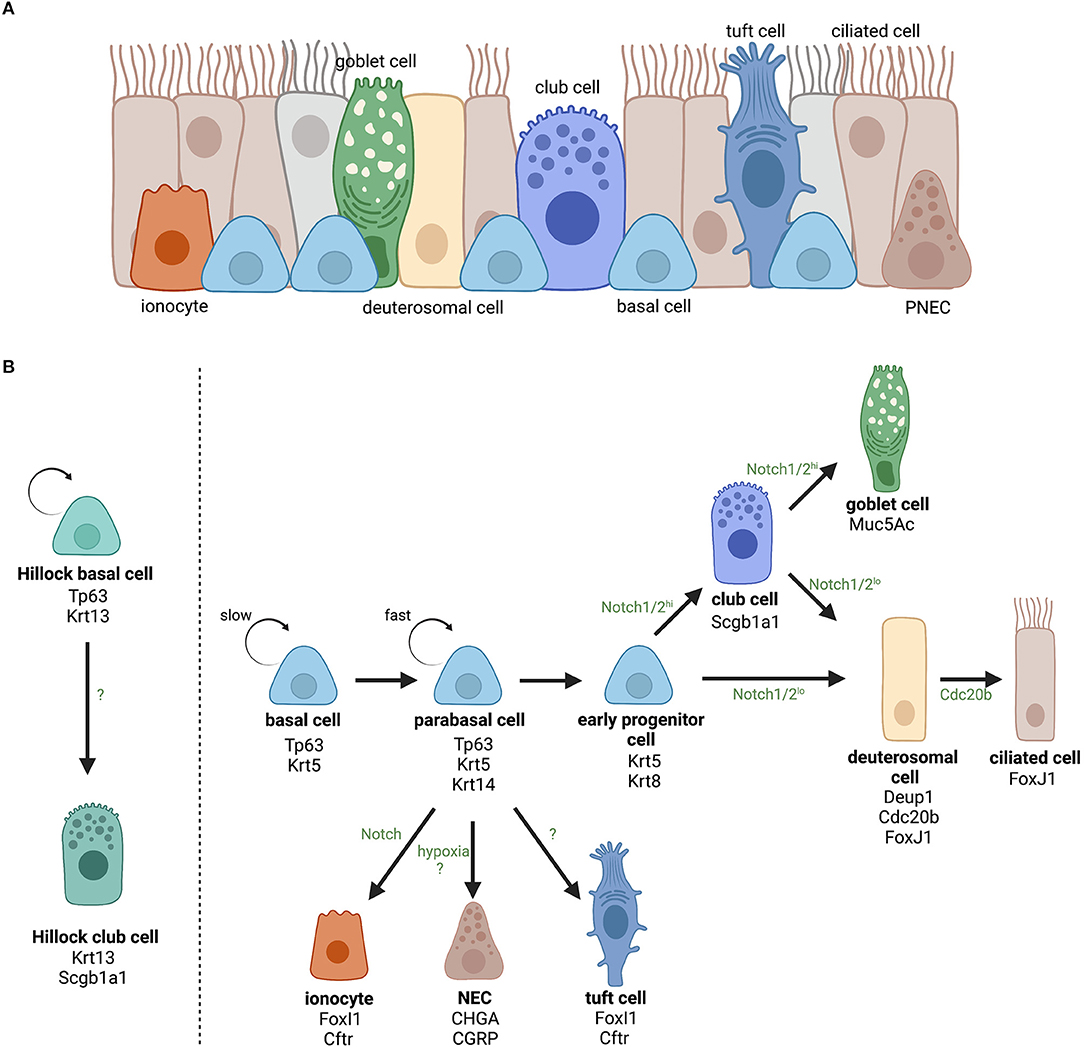

In [ ]:
mapping = {
    'AT2 proliferating': ['Alveolar cell type 2', 'transitional club/AT2'],
    'Adventitial fibroblasts': ['Fibroblast adventitial'],
    'Alveolar fibroblasts': ['Fibroblast alveolar'],
    'Alveolar macrophages': ['Macrophage alveolar'],
    'B cells': ['B cell'],
    'Basal resting': ['ROS1+ healthy epithelial'],
    'CD4 T cells': ['T cell CD4'],
    'CD8 T cells': ['T cell CD8 activated', 'T cell CD8 effector memory', 'T cell CD8 naive', 'T cell CD8 terminally exhausted'],
    'Classical monocytes': ['Monocyte classical'],
    'Club': ['Club'],
    'DC1': ['cDC1'],
    'DC2': ['cDC2'],
    'Deuterosomal': ['Ciliated'],
    'EC aerocyte capillary': ['Endothelial cell capillary'],
    'EC general capillary': ['Endothelial cell capillary'],
    'EC venous pulmonary': ['Endothelial cell venous'],
    'EC venous systemic': ['Endothelial cell venous'],
    'Goblet': ['ROS1+ healthy epithelial'],
    'Interstitial macrophages': ['Macrophage'],
    'Ionocyte': ['Smooth muscle cell'],
    'Migratory DCs': ['DC mature'],
    'Multiciliated': ['Ciliated'],
    'NK cells': ['NK cell'],
    'Neuroendocrine': ['Tumor cells LUAD NE'],
    'Non-classical monocytes': ['Monocyte non-classical'],
    'None': [],  # Assuming no corresponding entry
    'Peribronchial fibroblasts': ['Fibroblast peribronchial'],
    'Pericytes': ['Pericyte'],
    'Plasma cells': ['Plasma cell'],
    'Plasmacytoid DCs': ['pDC'],
    'SMG duct': ['ROS1+ healthy epithelial'],
    'SMG mucous': ['ROS1+ healthy epithelial'],
    'SMG serous': ['ROS1+ healthy epithelial'],
    'Subpleural fibroblasts': ['Fibroblast peribronchial'],
    'Suprabasal': ['ROS1+ healthy epithelial'],
    'T cells proliferating': ['T cell CD4 dividing', 'T cell CD8 dividing'],
    'Transitional Club-AT2': ['transitional club/AT2'],
    'Tuft': ['ROS1+ healthy epithelial']
}

In [117]:
annot_obs = adata_annot.obs

In [118]:
annot_obs.Level_4_transfered_label_unfiltered

0         3_Mast cells
1          CD8 T cells
2          CD4 T cells
3          CD4 T cells
4         3_Mast cells
              ...     
488231     CD4 T cells
488232     CD8 T cells
488233     CD4 T cells
488234     CD4 T cells
488235     CD8 T cells
Name: Level_4_transfered_label_unfiltered, Length: 488236, dtype: category
Categories (46, object): ['2_Mesothelium', '2_Smooth muscle', '3_AT1', '3_AT2', ..., 'Suprabasal', 'T cells proliferating', 'Transitional Club-AT2', 'Tuft']

In [ ]:
def get_highest_level(row):
    row

In [122]:
annot_obs.iloc[1,:]

Level_1_transfered_label_unfiltered            Immune
Level_2_transfered_label_unfiltered          Lymphoid
Level_3_transfered_label_unfiltered    T cell lineage
Level_4_transfered_label_unfiltered       CD8 T cells
Level_5_transfered_label_unfiltered     4_CD8 T cells
Level_1_transfered_label                       Immune
Level_2_transfered_label                     Lymphoid
Level_3_transfered_label               T cell lineage
Level_4_transfered_label                  CD8 T cells
Level_5_transfered_label                4_CD8 T cells
Name: 1, dtype: object

In [124]:
annot_obs.Level_4_transfered_label_unfiltered

0         3_Mast cells
1          CD8 T cells
2          CD4 T cells
3          CD4 T cells
4         3_Mast cells
              ...     
488231     CD4 T cells
488232     CD8 T cells
488233     CD4 T cells
488234     CD4 T cells
488235     CD8 T cells
Name: Level_4_transfered_label_unfiltered, Length: 488236, dtype: category
Categories (46, object): ['2_Mesothelium', '2_Smooth muscle', '3_AT1', '3_AT2', ..., 'Suprabasal', 'T cells proliferating', 'Transitional Club-AT2', 'Tuft']